# CNN(Convolutional Neural Network)

## 공통 코드

In [8]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩 명령입니다.
    %tensorflow_version 2.x
except Exception:
    pass

# 이 노트북은 텐서플로 ≥2.4이 필요합니다
# 2.x 버전은 대부분 동일한 결과를 만들지만 몇 가지 버그가 있습니다.
import tensorflow as tf
from tensorflow import keras

# 공통 모듈 임포트
import numpy as np
import pandas as pd

import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "CNN"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 구글 드라이브 마운트

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

### 합성곱 구현

In [3]:
#이미지 출력 함수
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [4]:
!pip install Pillow

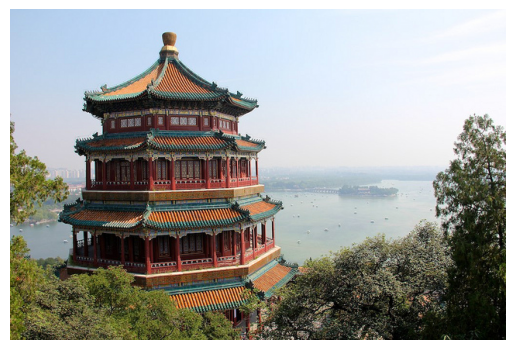

In [5]:
import PIL.Image as Image
#이미지 가져오기 및 출력
china = np.array(Image.open("./data/china.jpg")) / 255
flower = np.array(Image.open("./data/flower.jpg")) / 255
images = np.array([china, flower])
plt.imshow(china)
plt.axis("off")
plt.show()

In [6]:
print(images.shape)

(2, 427, 640, 3)


2024-03-21 07:11:44.715933: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-03-21 07:11:44.715960: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-21 07:11:44.716020: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-21 07:11:44.716098: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-21 07:11:44.716140: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


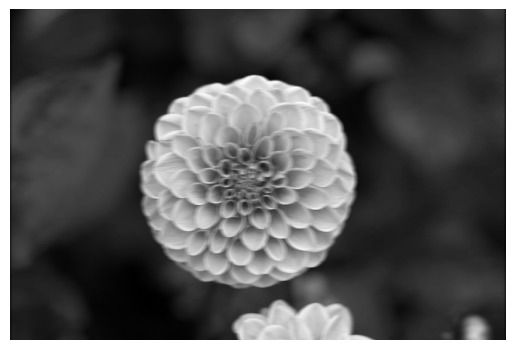

In [7]:
batch_size, height, width, channels = images.shape

# Create 2 filters
# 필터는 입력 데이터 와 연산에 사용할 행렬입니다.
# 홀수 의 정방 행렬로 만들고 특정 방향으로만 1을 설정하고 나머지는 0
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line
#print(filters)

#합성 곱 층에 대입
#첫번째가 입력 데이터, 두번째가 필터
#세번째가 스타라이드(보폭), 네번째는 패딩 여부
#입력은 4D 텐서 - 미니 배치 형식
#필터도 4D 텐서
#strides는 1이나 4개의 원소를 갖는 1D 배열
#첫번째 와 네번째는 1이고 두번째 와 세번째 요소가 수직 수평 스트라이드
#padding은 SAME(제로 패딩 사용) 이나 VALID(패딩 사용 안함)
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")
#결과 출력
plt.imshow(outputs[1, :, :, 1], cmap="gray")
plt.axis("off")
plt.show()

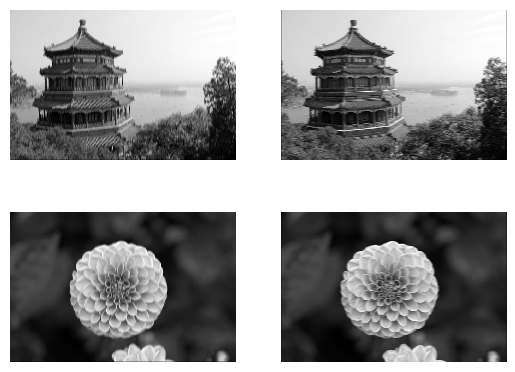

In [8]:
#이미지 출력
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

그림 저장: china_original


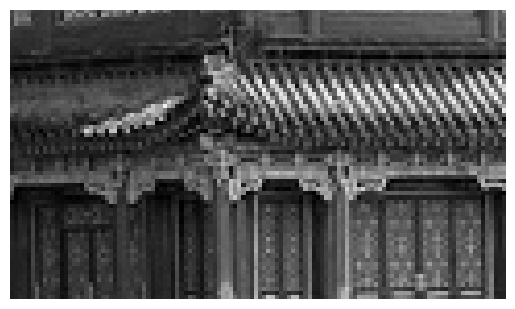

그림 저장: china_vertical


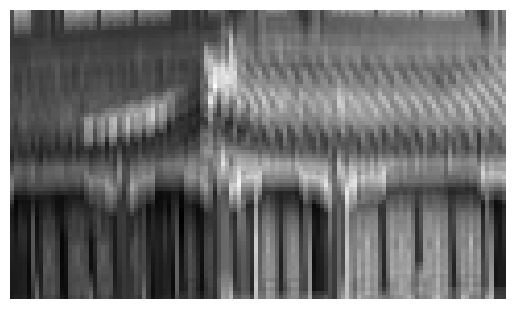

그림 저장: china_horizontal


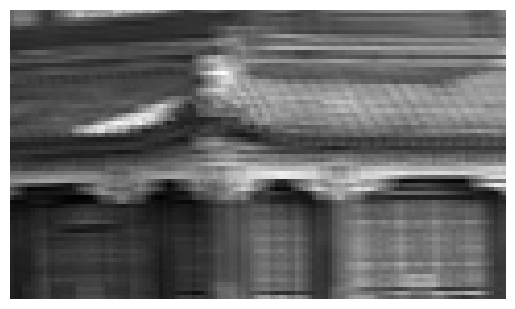

In [9]:
def crop(images):
    return images[150:220, 130:250]

plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

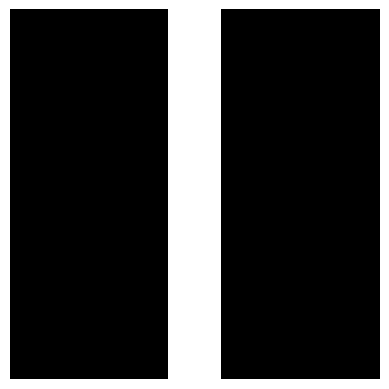

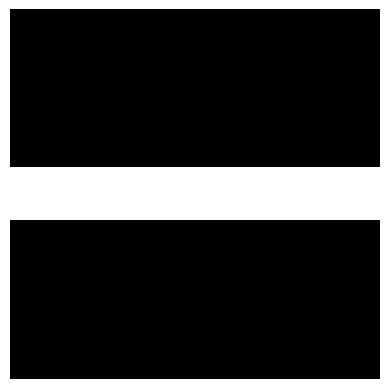

In [10]:
# 필터 확인
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

### Conv2D 에 필터 적용

In [11]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

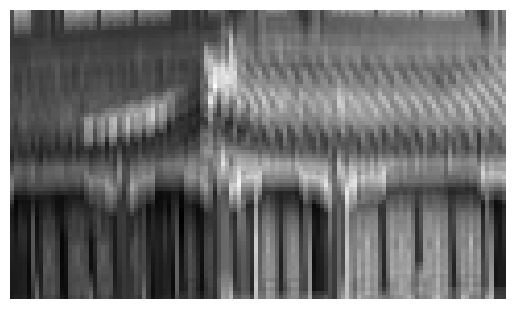

In [12]:
plot_image(crop(outputs[0, :, :, 0]))
plt.show()

### Pooling Layer

#### Max Pooling

In [13]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [14]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

그림 저장: china_max_pooling


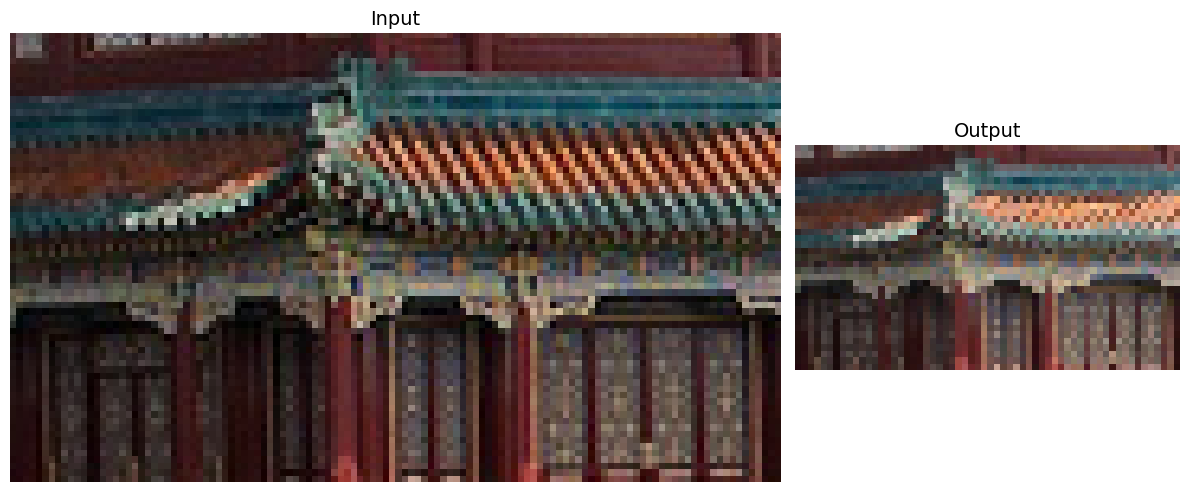

In [15]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

#### Average Pooling

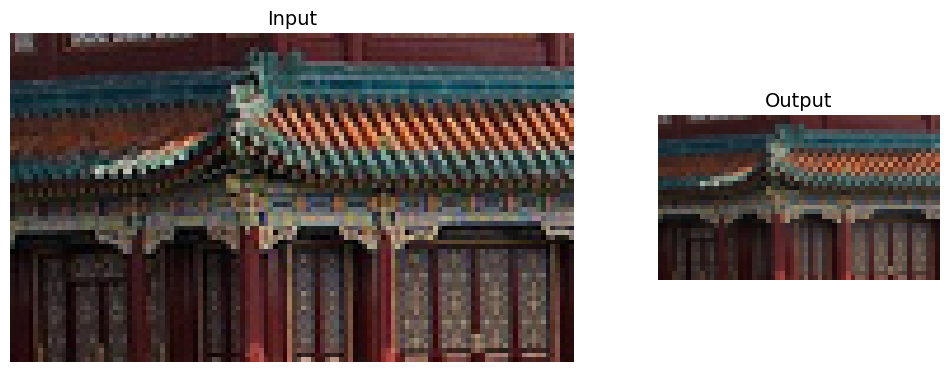

In [16]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

output_avg = avg_pool(cropped_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

#### Depth-wise pooling

In [17]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [18]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

In [19]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

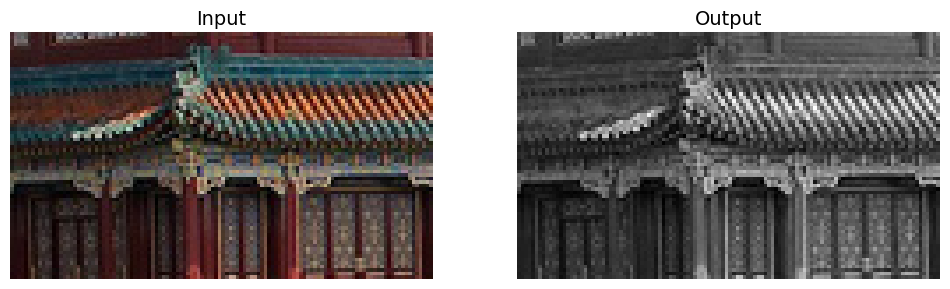

In [20]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

#### Global Average Pooling Layer

In [21]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.2250719 , 0.20967275],
       [0.51288515, 0.45951635, 0.33423483]], dtype=float32)>

In [22]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.2250719 , 0.20967275],
       [0.51288515, 0.45951635, 0.33423483]], dtype=float32)>

### 합성곱 신경망을 이용한 패션 이미지 분류

#### 데이터 불러오기

In [23]:
#데이터 가져오기
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
#스케일링
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

#### 합성곱 신경망 만들기

In [24]:
model = keras.Sequential()

#32는 필터(커널)의 개수
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same',
                              input_shape=(28,28,1)))

model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))

#Dense 전에는 1차원으로 만드는 작업이 필요해서 1차원 Layer 생성
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
#Dropout은 사용할 뉴런을 랜덤하게 추출하기 위한 레이어
#제거할 비율을 설정
model.add(keras.layers.Dropout(0.4))
#출력 층 - 뉴런의 개수가 1 또는 분류할 클래스의 개수
#분류는 출력의 activation이 softmax
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

/Users/adam/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       313,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,526 (1.27 MB)

 Trainable params: 333,526 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [26]:
keras.utils.plot_model(model, show_shapes=True, to_file='cnn-architecture.png', dpi=300)

You must install pydot (`pip install pydot`) for `plot_model` to work.


#### 모델 컴파일 과 훈련

In [27]:
#컴파일 - 최적화 함수는 adam
#loss 는 손실 함수
#metrics 는 평가 지표
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#callback은 이벤트가 발생할 때 마다 호출되는 함수 나 객체

#하나의 epoch 마다 체크하기 위한 부분
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.keras')
#2번이상 평가 지표가 좋아지지 않으면 조기 종료
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

#실제 훈련
history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])


Epoch 1/20


2024-03-21 07:11:46.947851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.7352 - loss: 0.7255 - val_accuracy: 0.8818 - val_loss: 0.3242
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.8651 - loss: 0.3741 - val_accuracy: 0.8991 - val_loss: 0.2764
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.8858 - loss: 0.3150 - val_accuracy: 0.9050 - val_loss: 0.2558
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.8960 - loss: 0.2818 - val_accuracy: 0.9048 - val_loss: 0.2623
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.9076 - loss: 0.2534 - val_accuracy: 0.9116 - val_loss: 0.2373
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.9143 - loss: 0.2288 - val_accuracy: 0.9154 - val_loss: 0.2313
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.9197 - loss: 0.2120 - val_accuracy: 0.9170 - val_loss: 0.2250
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.9261 - loss: 0.19

#### 손실 함수 출력

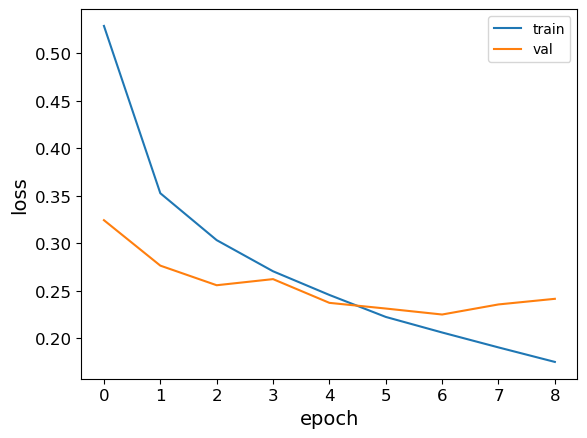

In [28]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

#### 모델 평가 와 예측

In [29]:
model.evaluate(val_scaled, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9181 - loss: 0.2181


[0.2250218540430069, 0.9169999957084656]

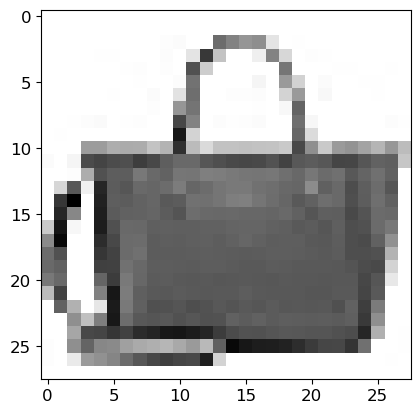

In [30]:
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

In [31]:
preds = model.predict(val_scaled[0:1])
print(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
[[2.3847917e-19 1.3467017e-27 4.8651278e-21 1.0643049e-20 4.2112867e-20
  2.2617730e-18 3.1596523e-17 3.1318213e-19 1.0000000e+00 7.2850257e-22]]


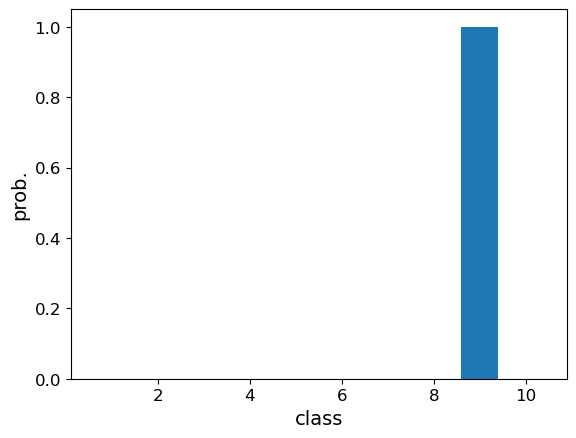

In [32]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [33]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트',
           '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

In [34]:
import numpy as np
print(classes[np.argmax(preds)])

가방


In [35]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

In [36]:
model.evaluate(test_scaled, test_target)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9109 - loss: 0.2638


[0.24716021120548248, 0.9114000201225281]

In [37]:
model.save('best-cnn-model.h5')

### 합성곱 신경망의 시각화

#### 이전 모델 가져오기

In [38]:
model = keras.models.load_model('best-cnn-model.keras')

In [39]:
model.layers

[<Conv2D name=conv2d_1, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Conv2D name=conv2d_2, built=True>,
 <MaxPooling2D name=max_pooling2d_2, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dropout name=dropout, built=True>,
 <Dense name=dense_1, built=True>]

#### 가중치 확인

In [40]:
conv = model.layers[0]
#3 * 3 은 커널의 사이즈, 1은 채널의 개수, 32는 커널의 개수
print(conv.weights[0].shape, conv.weights[1].shape)

(3, 3, 1, 32) (32,)


In [41]:
conv_weights = conv.weights[0].numpy()

print(conv_weights.mean(), conv_weights.std())

-0.017205678 0.2454669


#### 가중치 분포 확인

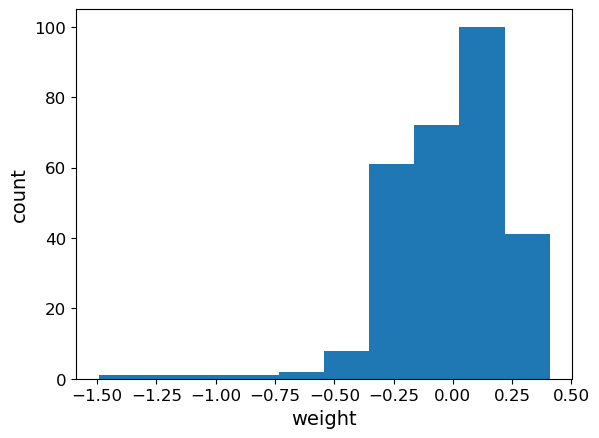

In [42]:
import matplotlib.pyplot as plt

plt.hist(conv_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

#### 32개 커널을 16개씩 출력

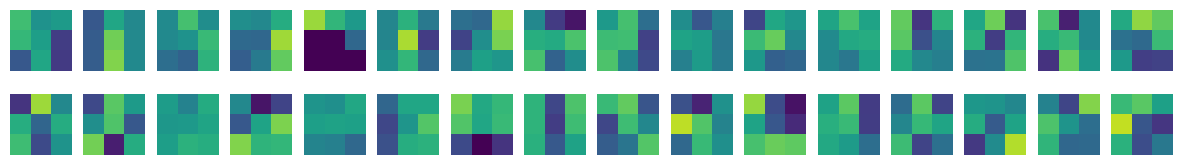

In [43]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))

for i in range(2):
    for j in range(16):
        axs[i, j].imshow(conv_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')

plt.show()

#### 훈련하지 않은 빈 신경망 생성

In [44]:
no_training_model = keras.Sequential()

no_training_model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                                          padding='same', input_shape=(28,28,1)))

#### 첫번째 층의 가중치를 저장

In [45]:
no_training_conv = no_training_model.layers[0]

print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


#### 가중치의 평균 과 표준편차

In [46]:
no_training_weights = no_training_conv.weights[0].numpy()

print(no_training_weights.mean(), no_training_weights.std())

0.003353602 0.08284039


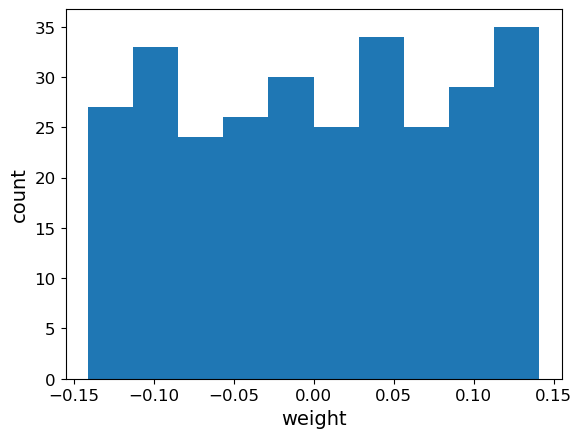

In [47]:
plt.hist(no_training_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

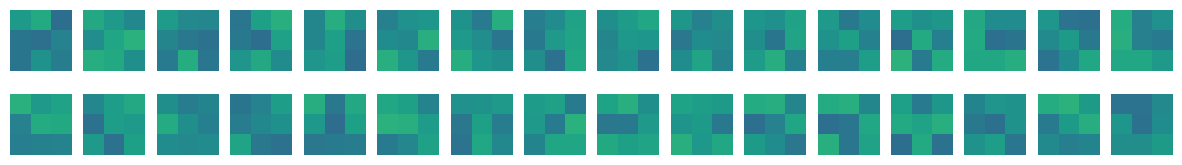

In [48]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))

for i in range(2):
    for j in range(16):
        axs[i, j].imshow(no_training_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')

plt.show()

## CNN 을 활용한 교통 표지판 인식

### 데이터 가져오고 전처리

In [ ]:
#!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

In [ ]:
#!unzip -qq "GTSRB_Final_Training_Images.zip"

In [3]:
N_CLASSES = 43
RESIZED_IMAGE = (32, 32)

import matplotlib.pyplot as plt
import glob
from skimage.color import rgb2lab
from skimage.transform import resize
from collections import namedtuple
import numpy as np
np.random.seed(101)
%matplotlib inline

Dataset = namedtuple('Dataset', ['X', 'y'])

def to_tf_format(imgs):
    return np.stack([img[:, :, np.newaxis] for img in imgs], axis=0).astype(np.float32)

def read_dataset_ppm(rootpath, n_labels, resize_to):
  images = []
  labels = []
  print(n_labels)
  for c in range(n_labels):
    full_path = rootpath + '/' + format(c, '05d') + '/'
    for img_name in glob.glob(full_path + "*.ppm"):

      img = plt.imread(img_name).astype(np.float32)
      img = rgb2lab(img / 255.0)[:,:,0]
      if resize_to:
        img = resize(img, resize_to, mode='reflect')

      label = np.zeros((n_labels, ), dtype=np.float32)
      label[c] = 1.0

      images.append(img.astype(np.float32))
      labels.append(label)
  return Dataset(X = to_tf_format(images).astype(np.float32),
                 y = np.matrix(labels).astype(np.float32))

dataset = read_dataset_ppm('./data/GTSRB/Final_Training/Images', N_CLASSES, RESIZED_IMAGE)
#dataset = read_dataset_ppm('GTSRB/Final_Training/Images', N_CLASSES, RESIZED_IMAGE)
print(dataset.X.shape)
print(dataset.y.shape)

43
(39209, 32, 32, 1)
(39209, 43)


### 이미지 출력

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


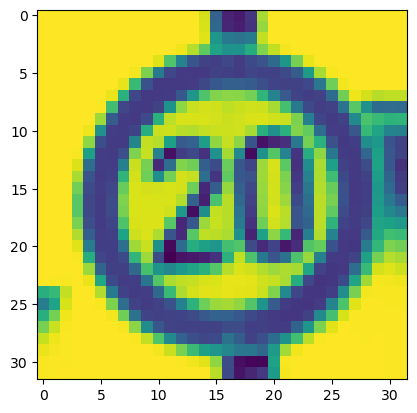

In [4]:
plt.imshow(dataset.X[0, :, :, :].reshape(RESIZED_IMAGE)) #sample
print(dataset.y[0, :]) #label

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


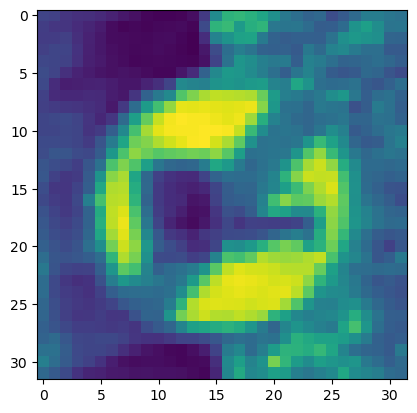

In [5]:
plt.imshow(dataset.X[-1, :, :, :].reshape(RESIZED_IMAGE)) #sample
print(dataset.y[-1, :]) #label

### 훈련 데이터 와 테스트 데이터 생성

In [6]:
from sklearn.model_selection import train_test_split
idx_train, idx_test = train_test_split(range(dataset.X.shape[0]), test_size=0.25, random_state=101)
X_train = dataset.X[idx_train, :, :, :]
X_test = dataset.X[idx_test, :, :, :]
y_train = dataset.y[idx_train, :]
y_test = dataset.y[idx_test, :]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

ar = []


ar = []
for i in np.asarray(y_train):
    for k, j in enumerate(i):
       if j == 1:
            ar.append(k)
y_train = np.array(ar)

ar = []
for i in np.asarray(y_test):
    for k, j in enumerate(i):
       if j == 1:
            ar.append(k)
y_test = np.array(ar)

(29406, 32, 32, 1)
(29406, 43)
(9803, 32, 32, 1)
(9803, 43)


### 신경망 생성

In [9]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same',
                              input_shape=(32,32,1)))

model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))

model.add(keras.layers.Dense(43, activation='softmax'))

model.summary()

/Users/adam/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-03-21 07:23:22.560646: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-03-21 07:23:22.560682: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-21 07:23:22.560692: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-21 07:23:22.560724: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-21 07:23:22.560748: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/repl

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       409,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         4,343 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 432,859 (1.65 MB)

 Trainable params: 432,859 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

### 모델 훈련

In [11]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.keras')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20,
                    callbacks=[checkpoint_cb, early_stopping_cb])


Epoch 1/20


2024-03-21 07:23:56.818856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


919/919 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.0544 - loss: 3.9392
Epoch 2/20
  8/919 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.0307 - loss: 3.5705

/Users/adam/anaconda3/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


919/919 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.0569 - loss: 3.5400
Epoch 3/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.0569 - loss: 3.5012
Epoch 4/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.0564 - loss: 3.4919
Epoch 5/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.0566 - loss: 3.4894
Epoch 6/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.0565 - loss: 3.4887
Epoch 7/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.0565 - loss: 3.4878
Epoch 8/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.0566 - loss: 3.4890
Epoch 9/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.0650 - loss: 3.4599
Epoch 10/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.5132 - loss: 1.6147
Epoch 11/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.7052 - loss: 0.9193
Epoch 12/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.7900 - loss: 0.6627
Epoch 13/20
919/919 ━━━━━━━━━━━━━━━━━━━━

## CNN을 활용한 MNIST 이미지 분류

### Sequential API를 이용한 이미지 분류

#### 데이터 가져오기

In [12]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_valid, y_valid) = mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


#### 샘플 이미지 출력

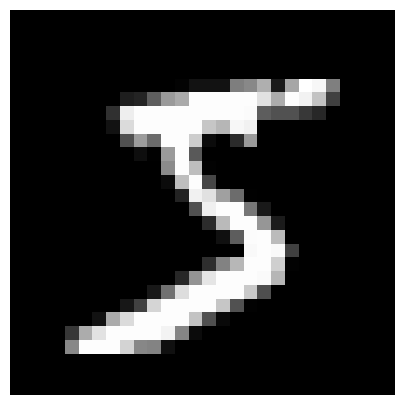

In [13]:
import matplotlib.pylab as plt

def plot_image(data, idx):
    plt.figure(figsize=(5, 5))
    plt.imshow(data[idx], cmap="gray")
    plt.axis("off")
    plt.show()

plot_image(x_train, 0)

#### 값의 범위 확인

In [14]:
print(x_train.min(), x_train.max())
print(x_valid.min(), x_valid.max())

0 255
0 255


#### 정규화

In [15]:
x_train = x_train / 255.0
x_valid = x_valid / 255.0

print(x_train.min(), x_train.max())
print(x_valid.min(), x_valid.max())

0.0 1.0
0.0 1.0


#### 채널 추가

In [16]:
# 채널 추가
print(x_train.shape, x_valid.shape)

x_train_in = x_train[..., tf.newaxis]
x_valid_in = x_valid[..., tf.newaxis]

print(x_train_in.shape, x_valid_in.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28, 1) (10000, 28, 28, 1)


#### CNN 생성

In [17]:
# Sequential API를 사용하여 샘플 모델 생성
model = tf.keras.Sequential([
    # Convolution 적용 (32 filters)
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                           input_shape=(28, 28, 1), name='conv'),
    # Max Pooling 적용
    tf.keras.layers.MaxPooling2D((2, 2), name='pool'),
    # Classifier 출력층
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax'),
])

#### 모델 컴파일 및 훈련

In [18]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(x_train_in, y_train,
                    validation_data=(x_valid_in, y_valid),
                    epochs=10)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.8803 - loss: 0.4190 - val_accuracy: 0.9704 - val_loss: 0.0947
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9762 - loss: 0.0862 - val_accuracy: 0.9765 - val_loss: 0.0688
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9823 - loss: 0.0620 - val_accuracy: 0.9794 - val_loss: 0.0636
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9856 - loss: 0.0501 - val_accuracy: 0.9798 - val_loss: 0.0618
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9881 - loss: 0.0416 - val_accuracy: 0.9812 - val_loss: 0.0604
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9903 - loss: 0.0348 - val_accuracy: 0.9820 - val_loss: 0.0598
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9924 - loss: 0.0290 - val_accuracy: 0.9819 - val_loss: 0.0609
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9940 - loss: 0

#### 모델 평가

In [19]:
model.evaluate(x_valid_in, y_valid)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9784 - loss: 0.0834


[0.06997060775756836, 0.9814000129699707]

#### 손실과 정밀도 그래프

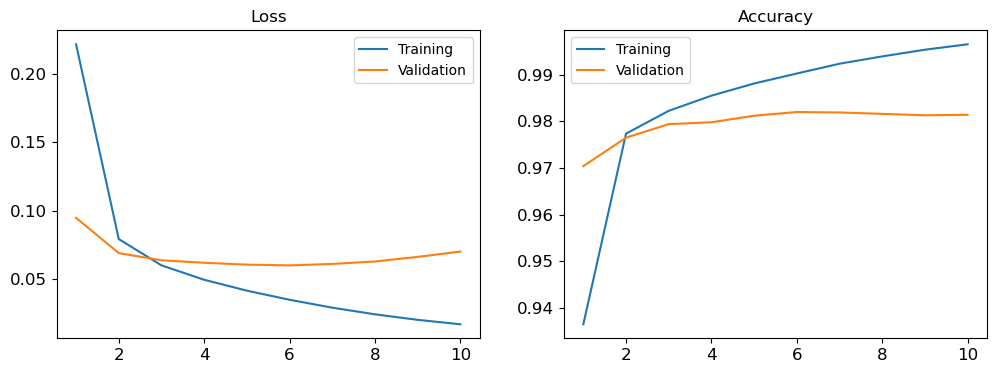

In [20]:
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

plot_loss_acc(history, 10)

### 함수형 API 활용

#### 새로운 출력 생성 - 홀수:1, 짝수:0

In [21]:
# 새로운 출력값 배열을 생성 (홀수: 1, 짝수: 0)
y_train_odd = []
for y in y_train:
    if y % 2==0:
        y_train_odd.append(0)
    else:
        y_train_odd.append(1)

y_train_odd = np.array(y_train_odd)
y_train_odd.shape

(60000,)

In [22]:
print(y_train[:10])
print(y_train_odd[:10])

[5 0 4 1 9 2 1 3 1 4]
[1 0 0 1 1 0 1 1 1 0]


#### 검증 데이터 처리

In [23]:
# Validation 데이터셋 처리
y_valid_odd = []
for y in y_valid:
    if y % 2==0:
        y_valid_odd.append(0)
    else:
        y_valid_odd.append(1)

y_valid_odd = np.array(y_valid_odd)
y_valid_odd.shape

(10000,)

#### 데이터 전처리

In [24]:
# 정규화(Normalization)
x_train = x_train / 255.0
x_valid = x_valid / 255.0

# 채널 추가
x_train_in = tf.expand_dims(x_train, -1)
x_valid_in = tf.expand_dims(x_valid, -1)

print(x_train_in.shape, x_valid_in.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


#### Functional API 를 이용하여 다중 입력 및 다중 출력 모델 생성

In [25]:
# Functional API를 사용하여 모델 생성

inputs = tf.keras.layers.Input(shape=(28, 28, 1))

conv = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)
flat = tf.keras.layers.Flatten()(pool)

flat_inputs = tf.keras.layers.Flatten()(inputs)
concat = tf.keras.layers.Concatenate()([flat, flat_inputs])
outputs = tf.keras.layers.Dense(10, activation='softmax')(concat)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 26, 26,    │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 13, 13,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 5408)      │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 784)       │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 6192)      │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10)        │     61,930 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 62,250 (243.16 KB)

 Trainable params: 62,250 (243.16 KB)

 Non-trainable params: 0 (0.00 B)

#### 모델 구조 출력 및 이미지 파일로 저장

In [26]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='functional_cnn.png')

You must install pydot (`pip install pydot`) for `plot_model` to work.


#### 모델 컴파일 및 훈련 과 평가

In [27]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(x_train_in, y_train,
                    validation_data=(x_valid_in, y_valid),
                    epochs=10)

# 모델 성능
val_loss, val_acc = model.evaluate(x_valid_in, y_valid)
print(val_loss, val_acc)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.6108 - loss: 1.5750 - val_accuracy: 0.8757 - val_loss: 0.4408
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.8803 - loss: 0.4208 - val_accuracy: 0.9028 - val_loss: 0.3414
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.8970 - loss: 0.3489 - val_accuracy: 0.9109 - val_loss: 0.3140
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9030 - loss: 0.3256 - val_accuracy: 0.9136 - val_loss: 0.3007
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9076 - loss: 0.3134 - val_accuracy: 0.9156 - val_loss: 0.2929
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9102 - loss: 0.3052 - val_accuracy: 0.9170 - val_loss: 0.2873
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9126 - loss: 0.2992 - val_accuracy: 0.9183 - val_loss: 0.2830
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9145 - los

#### Multi Output 모델

In [37]:
# Functional API를 사용하여 모델 생성

inputs = tf.keras.layers.Input(shape=(28, 28, 1), name='inputs')
conv = tf.keras.layers.Conv2D(32,(3, 3), activation='relu', name='conv2d_layer')(inputs)
pool = tf.keras.layers.MaxPooling2D((2, 2), name='maxpool_layer')(conv)
flat = tf.keras.layers.Flatten(name='flatten_layer')(pool)

flat_inputs = tf.keras.layers.Flatten()(inputs)
concat = tf.keras.layers.Concatenate()([flat, flat_inputs])
digit_outputs = tf.keras.layers.Dense(10, activation='softmax', name='digit_dense')(concat)

odd_outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='odd_dense')(flat_inputs)

model = tf.keras.models.Model(inputs=inputs, outputs=[digit_outputs, odd_outputs])

model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 28, 28, 1) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_layer        │ (None, 26, 26,    │        320 │ inputs[0][0]      │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool_layer       │ (None, 13, 13,    │          0 │ conv2d_layer[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_layer       │ (None, 5408)      │          0 │ maxpool_layer[0]… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 784)       │          0 │ inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 6192)      │          0 │ flatten_layer[0]… │
│ (Concatenate)       │                   │            │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit_dense (Dense) │ (None, 10)        │     61,930 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ odd_dense (Dense)   │ (None, 1)         │        785 │ flatten_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 63,035 (246.23 KB)

 Trainable params: 63,035 (246.23 KB)

 Non-trainable params: 0 (0.00 B)

#### 모델의 입력과 출력을 나타내는 텐서

In [38]:
print(model.input)
print(model.output)

<KerasTensor shape=(None, 28, 28, 1), dtype=float32, sparse=None, name=inputs>
[<KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_61>, <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_62>]


#### 모델 구조 이미지 저장

In [39]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='multi_output_cnn.png')

You must install pydot (`pip install pydot`) for `plot_model` to work.


#### 모델 컴파일 및 훈련

In [43]:
# 모델 컴파일
model.compile(optimizer='adam', 
              loss={'digit_dense': 'sparse_categorical_crossentropy', 'odd_dense': 'binary_crossentropy'}, 
              loss_weights={'digit_dense': 1.0, 'odd_dense': 0.5}, # loss = 1.0 *sparse_categorical_crossentropy + 0.5*binary_crossentropy
              metrics=['accuracy', 'accuracy'])

# 모델 훈련
history = model.fit({'inputs': x_train_in}, {'digit_dense': y_train, 'odd_dense': y_train_odd}, 
                    validation_data=({'inputs': x_valid_in},  {'digit_dense': y_valid, 'odd_dense': y_valid_odd}), 
                    epochs=10)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - digit_dense_accuracy: 0.5287 - loss: 2.1707 - odd_dense_accuracy: 0.6942 - val_digit_dense_accuracy: 0.8524 - val_loss: 0.9072 - val_odd_dense_accuracy: 0.7969
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - digit_dense_accuracy: 0.8616 - loss: 0.8500 - odd_dense_accuracy: 0.7963 - val_digit_dense_accuracy: 0.8891 - val_loss: 0.6957 - val_odd_dense_accuracy: 0.8010
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - digit_dense_accuracy: 0.8868 - loss: 0.6924 - odd_dense_accuracy: 0.8000 - val_digit_dense_accuracy: 0.9032 - val_loss: 0.6279 - val_odd_dense_accuracy: 0.8039
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - digit_dense_accuracy: 0.8966 - loss: 0.6346 - odd_dense_accuracy: 0.8042 - val_digit_dense_accuracy: 0.9098 - val_loss: 0.5917 - val_odd_dense_accuracy: 0.8084
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - digit_dense_accuracy: 0.9027 - loss: 0.6017 - odd_dense_accuracy: 0.80

#### 모델 평가

In [44]:
model.evaluate({'inputs': x_valid_in}, {'digit_dense': y_valid, 'odd_dense': y_valid_odd})

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - digit_dense_accuracy: 0.9046 - loss: 0.5453 - odd_dense_accuracy: 0.8142


[0.5021020770072937, 0.9179999828338623, 0.826200008392334]

#### 샘플 이미지 출력

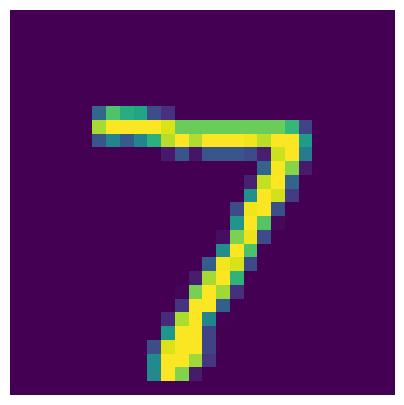

In [45]:
import matplotlib.pylab as plt

def plot_image(data, idx):
    plt.figure(figsize=(5, 5))
    plt.imshow(data[idx])
    plt.axis("off")
    plt.show()

plot_image(x_valid, 0)

#### 모델 예측

In [46]:
digit_preds, odd_preds = model.predict(x_valid_in)
print(digit_preds[0])
print(odd_preds[0])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[8.1633851e-07 5.8622732e-11 9.8952717e-07 1.2895743e-04 1.0968135e-07
 2.2078295e-06 1.3134958e-10 9.9961460e-01 4.0257976e-07 2.5200841e-04]
[0.8214826]


In [47]:
digit_labels = np.argmax(digit_preds, axis=-1)
digit_labels[0:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 6, 9])

In [49]:
odd_labels = (odd_preds > 0.5).astype(np.int8).reshape(1, -1)[0]
odd_labels[0:10]

array([1, 0, 1, 0, 0, 1, 1, 1, 0, 1], dtype=int8)

### 전이학습

#### 이전 모델을 이용해서 새로운 모델 생성

In [50]:
# 앞의 모델에서 flatten_layer 출력을 추출
base_model_output = model.get_layer('flatten_layer').output

# 앞의 출력을 출력으로 하는 모델 정의
base_model = tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base')
base_model.summary()

Model: "base"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer (Conv2D)           │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 5408)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320 (1.25 KB)

 Trainable params: 320 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

#### 모델 구조 저장

In [54]:
#!pip install pydot

In [55]:
keras.utils.plot_model(base_model, show_shapes=True, show_layer_names=True, to_file='base_model.png')

You must install pydot (`pip install pydot`) for `plot_model` to work.


#### 모델 생성

In [56]:
# Sequential API 적용
digit_model = tf.keras.Sequential([
                                   base_model,
                                   tf.keras.layers.Dense(10, activation='softmax'),
                                   ])
digit_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ base (Functional)               │ ?                      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320 (1.25 KB)

 Trainable params: 320 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

#### 모델 구조 저장

In [57]:
keras.utils.plot_model(digit_model, show_shapes=True, show_layer_names=True, to_file='digit_model.png')

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

#### 모델 컴파일 및 훈련

In [ ]:
# 모델 컴파일
digit_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = digit_model.fit(x_train_in, y_train,
                    validation_data=(x_valid_in, y_valid),
                    epochs=10)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.7503 - loss: 1.1792 - val_accuracy: 0.8868 - val_loss: 0.4159
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.8883 - loss: 0.4031 - val_accuracy: 0.9082 - val_loss: 0.3310
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9021 - loss: 0.3394 - val_accuracy: 0.9135 - val_loss: 0.3046
Epoch 4/10
 990/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9072 - loss: 0.3187

#### 베이스 모델의 가중치를 고정 (Freeze Model)

In [ ]:
base_model_frozen = tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base_frozen')
base_model_frozen.trainable = False
base_model_frozen.summary()

#### 함수형 API 적용

In [ ]:
dense_output = tf.keras.layers.Dense(10, activation='softmax')(base_model_frozen.output)
digit_model_frozen = tf.keras.models.Model(inputs=base_model_frozen.input, outputs=dense_output)
digit_model_frozen.summary()

#### 모델 컴파일 및 훈련

In [ ]:
# 모델 컴파일
digit_model_frozen.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = digit_model_frozen.fit(x_train_in, y_train,
                    validation_data=(x_valid_in, y_valid),
                    epochs=10)

#### 베이스 모델의 Conv2D 레이어의 가중치만 고정 (Freeze Layer)

In [ ]:
base_model_frozen2 = tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base_frozen2')
base_model_frozen2.get_layer('conv2d_layer').trainable = False
base_model_frozen2.summary()

#### 함수형 API 적용

In [ ]:
dense_output2 = tf.keras.layers.Dense(10, activation='softmax')(base_model_frozen2.output)
digit_model_frozen2 = tf.keras.models.Model(inputs=base_model_frozen2.input, outputs=dense_output2)
digit_model_frozen2.summary()

#### 모델 컴파일 및 훈련

In [ ]:
# 모델 컴파일
digit_model_frozen2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = digit_model_frozen2.fit(x_train_in, y_train,
                    validation_data=(x_valid_in, y_valid),
                    epochs=10)

## 데이터 증강

### 이미지 사이즈 조정 및 분류 작업

In [ ]:
#이미지 다운로드
!git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git

In [ ]:
import glob
from sklearn.model_selection import train_test_split

# 분류 대상 카테고리 선택하기 --- (※1)

#데이터 디렉토리 설정
caltech_dir = "Homework2-Caltech101/101_ObjectCategories"
#분류할 카테고리 이름
categories = ["chair","camera","butterfly","elephant","flamingo"]
#분류할 클래스 개수 설정
nb_classes = len(categories)

# 이미지 크기 지정 --- (※2)
image_w = 64
image_h = 64
pixels = image_w * image_h * 3



In [ ]:
#이미지 파일을 numpy 배열로 읽어오기 위한 패키지
from PIL import Image

# 이미지 데이터 읽어 들이기 --- (※3)

#이미지를 저장하기 위한 list
X = []
#타겟을 저장하기 위한 list
Y = []

#list를 순회할 때 index 와 value를 같이 가져오고자 하는 경우 enumerate 사용
for idx, cat in enumerate(categories):
  # 레이블 지정 --- (※4)

  #원핫 인코딩을 위해서 클래스 개수 만큼의 list를 생성
  label = [0 for i in range(nb_classes)]
  #idx 에 해당하는 부분에 1을 설정
  label[idx] = 1

  # 이미지 --- (※5)
  #카테고리에 해당하는 디렉토리 경로를 생성
  image_dir = caltech_dir + "/" + cat
  #디렉토리에서 확장자가 jpg 인 모든 파일의 경로를 문자열 list로 생성
  files = glob.glob(image_dir+"/*.jpg")

  #이미지 읽기
  for i, f in enumerate(files):
    #이미지 파일의 내용 읽기
    img = Image.open(f) # --- (※6)
    #이미지의 채널을 설정 - rgb로 변경
    img = img.convert("RGB")
    #이미지 리사이징 - 합성곱에 넣을 때는 이미지를 동일한 크기로 만들어 주어야 합니다.
    img = img.resize((image_w, image_h))
    #numpy 배열로 생성
    data = np.asarray(img)
    #리스트에 이미지 와 레이블을 추가
    X.append(data)
    Y.append(label)
    #작업을 수행하고 있는지 확인하기 위해서 출력
    if i % 10 == 0:
      print(i, "\n", data)

#리스트의 데이터를 numpy 배열로 생성
X = np.array(X)
Y = np.array(Y)


In [ ]:
# 학습 전용 데이터와 테스트 전용 데이터 구분 --- (※7)

#훈련 데이터 와 테스트 데이터를 분할한 후 튜플로 생성
X_train, X_test, y_train, y_test = train_test_split(X, Y)
xy = (X_train, X_test, y_train, y_test)

#데이터를 다시 사용하고자 하는 경우 numpy 배열로 저장해두면 나중에 읽어올 때 편리
#포트폴리오나 프로젝트를 진행하다 보면 데이터를 여러 번 호출해야 하는 경우가 발생
#이런 경우에는 numpy 파일로 저장해두고 읽으면 편리
#data 디렉토리에 image 디렉토리를 생성
#다음 주에 이 코드는 linux 명령어로 변환 - mkdir
np.save("./data/image/5obj.npy", xy)
print("ok,", len(Y))

In [ ]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import numpy as np

# 카테고리 지정하기
categories = ["chair","camera","butterfly","elephant","flamingo"]
nb_classes = len(categories)

# 이미지 크기 지정하기
image_w = 64
image_h = 64

# 데이터 불러오기 --- (※1)
# pickle - Serializable을 pickle을 가지고 수행
# Serializable(직렬화) - 객체 단위로 데이터를 전송
X_train, X_test, y_train, y_test = np.load("./data/image/5obj.npy", allow_pickle=True)

# 데이터 정규화하기
X_train = X_train.astype("float") / 256
X_test = X_test.astype("float") / 256
print('X_train shape:', X_train.shape)



In [ ]:
# 모델 구축하기 --- (※2)
model = Sequential()

print(X_train.shape[1:])
#입력 층을 합성 곱으로 생성
#커널의 개수는 32개 커널의 크기는 3 * 3, 제로 패딩 사용
#입력 층은 입력되는 데이터의 shape를 설정 - 데이터 개수는 제외
model.add(Convolution2D(32, kernel_size=3, padding='same',input_shape=(64,64,3)))
#활성화 함수 설정
model.add(Activation('relu'))
#2 * 2 만큼의 맵을 하나의 맵으로 변환하는데 최대값만 표시
#특성 맵의 크기가 줄어듬
model.add(MaxPooling2D(2))
#뉴런은 25%를 제거
model.add(Dropout(0.25))

#합성곱 층
model.add(Convolution2D(64, kernel_size=3, padding='same'))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3))

model.add(MaxPooling2D(2))
model.add(Dropout(0.25))

#완전 연결층 - 입력의 크기를 1차원으로
model.add(Flatten()) # --- (※3)
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#출력 층 생성 - 뉴런의 개수가 1 또는 클래스 개수
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [ ]:
model.compile(loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy'])

# 모델 훈련하기 --- (※4)
# 모델의 가중치만 파일로 저장하고 읽어오기
hdf5_file = "./data/image/5obj-model.hdf5"
if os.path.exists(hdf5_file):
  model.load_weights(hdf5_file)
else:
  model.fit(X_train, y_train, batch_size=32, epochs=50)
  model.save_weights(hdf5_file)

# 모델 평가하기--- (※5)
score = model.evaluate(X_test, y_test)
print('loss=', score[0])
print('accuracy=', score[1])

In [ ]:
img = Image.open('/content/drive/MyDrive/chair.png')
img = img.convert("RGB")
img = img.resize((image_w, image_h))
data = np.asarray(img)
data = data.astype("float") / 256
data = data.reshape(-1, 64, 64, 3)
score = model.predict(data)
print(score)
for category, prob in enumerate(zip(categories, score[0])):
  print(category, prob)


In [ ]:
# 모델 평가하기
pre = model.predict(X_test)
for i,v in enumerate(pre):
  pre_ans = v.argmax()
  ans = y_test[i].argmax()
  dat = X_test[i]
  if ans == pre_ans: continue
  print("[NG]", categories[pre_ans], "!=", categories[ans])
  print(v)
  fname = "./data/image/error/" + str(i) + "-" + categories[pre_ans] + "-ne-" + categories[ans] + ".png"
  dat *= 256
  img = Image.fromarray(np.uint8(dat))
  img.save(fname)


## 데이터 증강

### augmentor

In [ ]:
! pip install augmentor

In [ ]:
import Augmentor

#증강 시킬 이미지 폴더 경로
img = Augmentor.Pipeline("./data/sample")

# 좌우 반전
img.flip_left_right(probability=1.0)

# 상하 반전
img.flip_top_bottom(probability=1.0)

#모퉁이 왜곡
img.skew_corner(probability=1.0)

#회전&크롭
img.rotate_without_crop(probability=1, max_left_rotation=0.8, max_right_rotation=0.8, expand=False, fillcolor=None)

# 왜곡
img.random_distortion(probability=1, grid_width=10, grid_height=10, magnitude=30)

#확대
img.zoom_random(probability=1, percentage_area=0.8)

#크롭
img.crop_random(probability=1, percentage_area=0.8, randomise_percentage_area=False)

#랜덤 지우기
img.random_erasing(probability=1.0, rectangle_area=0.3)

# 증강 이미지 수
img.sample(4)

### ImageDataGenerator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

#옵션을 이용해서 이미지 증강을 위한 객체 생성
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

#어떤 그림을 증강할 지 선택
img = load_img('/content/drive/MyDrive/windsor_castle.jpg')  # PIL 이미지
x = img_to_array(img)  # (3, 150, 150) 크기의 NumPy 배열
#이미지 1개는 2D 텐서 나 3D 텐서
#케라스는 기본적으로 4D 텐서를 다룸
x = x.reshape((1,) + x.shape)  # (1, 3, 150, 150) 크기의 NumPy 배열

# 아래 .flow() 함수는 임의 변환된 이미지를 배치 단위로 생성해서
# 지정된 data/sample 디렉토리에 저장
# 파일의 이름 앞에는 adam을 추가하고 포맷은 jpeg
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='./data/sample', save_prefix='adam', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # 이미지 20장을 생성하고 마칩니다

### 개/고양이 분류

#### 데이터 가져오기

In [ ]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

In [ ]:
#zip 파일 압축 풀기
import shutil
shutil.unpack_archive('cats_and_dogs_filtered.zip', './data/dataset/')

In [ ]:
train_dir = "data/dataset/cats_and_dogs_filtered/train"
valid_dir = "data/dataset/cats_and_dogs_filtered/validation"
print(train_dir)
print(valid_dir)

#### 이미지 데이터 제너레이터 - 이미지 증강

In [ ]:
image_gen = ImageDataGenerator(rescale=(1/255.))
image_gen

In [ ]:
train_gen = image_gen.flow_from_directory(train_dir,
                                          batch_size=32,
                                          target_size=(224, 224),
                                          classes=['cats','dogs'],
                                          class_mode = 'binary',
                                          seed=2020)

valid_gen = image_gen.flow_from_directory(valid_dir,
                                          batch_size=32,
                                          target_size=(224, 224),
                                          classes=['cats','dogs'],
                                          class_mode = 'binary',
                                          seed=2020)


#### 샘플 이미지 출력

In [ ]:
class_labels = ['cats', 'dogs']
batch = next(train_gen)
images, labels = batch[0], batch[1]

plt.figure(figsize=(16, 8))
for i in range(32):

    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(images[i])
    plt.title(class_labels[labels[i].astype(np.int)])
    plt.axis("off")
plt.tight_layout()
plt.show()

#### 모델 생성

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        # Convolution 층
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Classifier 출력층
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    return model

In [ ]:
model = build_model()

#### 모델 컴파일 및 훈련 - 느림

In [ ]:
# 모델 컴파일
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_gen, validation_data=valid_gen, epochs=20)

#### 손실 및 정확도 그래프

In [ ]:
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()


plot_loss_acc(history, 20)

#### 이미지 증강 후 모델 생성 및 훈련

In [ ]:
# 이미지 데이터 제너레이터 정의 (Augmentation 적용)
image_gen_aug = ImageDataGenerator(rescale=1/255.,
                                   horizontal_flip=True,
                                   rotation_range=35,
                                   zoom_range=0.2)

# flow_from_directory 함수로 폴더에서 이미지 가져와서 제너레이터 객체로 정리
train_gen_aug = image_gen_aug.flow_from_directory(train_dir,
                                                  batch_size=32,
                                                  target_size=(224,224),
                                                  classes=['cats','dogs'],
                                                  class_mode = 'binary',
                                                  seed=2020)

valid_gen_aug = image_gen_aug.flow_from_directory(valid_dir,
                                                  batch_size=32,
                                                  target_size=(224,224),
                                                  classes=['cats','dogs'],
                                                  class_mode = 'binary',
                                                  seed=2020)


In [ ]:
# 모델 생성
model_aug = build_model()

# 모델 컴파일
model_aug.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

# 모델 훈련
history_aug = model_aug.fit(train_gen_aug, validation_data=valid_gen_aug, epochs=40)

In [ ]:
#앞에서 조기 종료가 되면 조기 종료된 epoch 값을 설정해야 합니다.
plot_loss_acc(history_aug, 40)

## 이미지 분류 전이 학습

### LeNet-5

#### 데이터 가져오기

In [ ]:
num_classes = 10
img_rows, img_cols, img_ch = 28, 28, 1
input_shape = (img_rows, img_cols, img_ch)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(x_train.shape[0], *input_shape)
x_test = x_test.reshape(x_test.shape[0], *input_shape)

#### 모델 클래스

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

class LeNet5(Model):

    def __init__(self, num_classes):
        """
        Initialize the model.
        :param num_classes:     Number of classes to predict from
        """
        super(LeNet5, self).__init__()
        # We instantiate the various layers composing LeNet-5:
        # self.conv1 = SimpleConvolutionLayer(6, kernel_size=(5, 5))
        # self.conv2 = SimpleConvolutionLayer(16, kernel_size=(5, 5))
        # ... or using the existing and (recommended) Conv2D class:
        self.conv1 = Conv2D(6, kernel_size=(5, 5), padding='same', activation='relu')
        self.conv2 = Conv2D(16, kernel_size=(5, 5), activation='relu')
        self.max_pool = MaxPooling2D(pool_size=(2, 2))
        self.flatten = Flatten()
        self.dense1 = Dense(120, activation='relu')
        self.dense2 = Dense(84, activation='relu')
        self.dense3 = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        """
        Call the layers and perform their operations on the input tensors
        :param inputs:  Input tensor
        :return:        Output tensor
        """
        x = self.max_pool(self.conv1(inputs))        # 1st block
        x = self.max_pool(self.conv2(x))             # 2nd block
        x = self.flatten(x)
        x = self.dense3(self.dense2(self.dense1(x))) # dense layers
        return x

#### 모델 컴파일

In [ ]:
model = LeNet5(num_classes)
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### 예측

In [ ]:
_ = model.predict(x_test[:10])

#### 모델 구조

In [ ]:
batched_input_shape = tf.TensorShape((None, *input_shape))
model.build(input_shape=batched_input_shape)
model.summary()

#### 콜백 생성

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True)]

#### 콜백 적용 후 훈련

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=32, epochs=80, validation_data=(x_test, y_test),
                    callbacks=callbacks)

### VGG

#### VGG 사전 학습 가중치를 이용한 이미지 분류

In [ ]:
'''
ref1:
https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5
ref2: # https://keras.io/applications/
'''
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications.imagenet_utils  import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image # pip install pillow

model = VGG16(weights='imagenet', include_top=True) # weights= W
model.summary()

img_path = '/content/drive/MyDrive/elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)  # (1, 224, 224, 3)
x = preprocess_input(x) # mode='caffe'
output = model.predict(x)

print('Predicted:', decode_predictions(output, top=5)[0])

k = np.argmax(output[0])            # top 1
z = output[0].argsort()[-5:][::-1]    # top 5

labels = {}
name = "/content/drive/MyDrive/imagenet1000_clsidx_to_labels.txt"
with open(name, 'r') as f:
    C = [line[:-2] for line in f.readlines()]
C[0] = C[0][1:]
for line in C:
    line = line.replace("'", "")
    key, value = line.split(':')
    labels[int(key)] = value.strip()
print('Top-1 prediction:', labels[k])
print('Top-5 prediction:', [labels[i] for i in z])

plt.imshow(img)
plt.title(labels[k])
plt.axis("off")
plt.show()


#### VGG16 구조를 이용한 이미지 분류 - 많이 느림

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') # (50000, 32, 32, 3)
x_test  = x_test.astype('float32')  # (10000, 32, 32, 3)

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

x_train= preprocess_input(x_train)
x_test = preprocess_input(x_test)

model = VGG16(weights=None, include_top=True, classes=10, input_shape=(32,32,3))
model.summary()

opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
ret = model.fit(x_train, y_train, epochs=100, batch_size=400,
                validation_split=0.2, verbose=1, callbacks = callbacks)
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].plot(ret.history['loss'],  "g-")
ax[0].set_title("train loss")
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')

ax[1].plot(ret.history['accuracy'],     "b-", label="train accuracy")
ax[1].plot(ret.history['val_accuracy'], "r-", label="val accuracy")
ax[1].set_title("accuracy")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
plt.legend(loc="best")
fig.tight_layout()
plt.show()

### Inception V3 를 이용한 CIFAR-10 분류

#### 라이브러리 import

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers   import Input, Conv2D, Dense
from tensorflow.keras.layers   import Flatten, MaxPooling2D, GlobalAveragePooling2D
import numpy as np
import matplotlib.pyplot as plt

#### 데이터 가져오기

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#### 데이터 전처리

In [ ]:
x_train = x_train.astype('float32') # (50000, 32, 32, 3)
x_test  = x_test.astype('float32')  # (10000, 32, 32, 3)

x_train = x_train / 255.0
x_test  = x_test / 255.0

# one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_test  = tf.keras.utils.to_categorical(y_test)

#### 간단한 Inception_Layer 구현

In [ ]:
inputs = Input(shape=(32, 32, 3))

L1 = Conv2D(64, (1,1), padding='same', activation='relu', name="L1")(inputs)
L2 = Conv2D(64, (3,3), padding='same', activation='relu', name="L2")(L1)

L3 = Conv2D(64, (1,1), padding='same', activation='relu')(inputs)
L3 = Conv2D(64, (5,5), padding='same', activation='relu', name="L3")(L3)

L4 = MaxPooling2D((3,3), strides=(1,1), padding='same')(inputs)
L4 = Conv2D(64, (1,1), padding='same', activation='relu', name="L4")(L4)
output = tf.keras.layers.concatenate([L1, L2, L3, L4], axis = 3)

output = Flatten()(output)
outs   = Dense(10, activation='softmax')(output)

#### 모델 생성 및 구조 확인

In [ ]:
model  = tf.keras.Model(inputs=inputs, outputs=outs)
model.summary()

#### 훈련 및 평가

In [ ]:
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
ret = model.fit(x_train, y_train, epochs=30, batch_size=128,
                validation_split=0.2, verbose=1, callbacks = callbacks)

train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].plot(ret.history['loss'],  "g-")
ax[0].set_title("train loss")
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')

ax[1].set_ylim(0, 1.1)
ax[1].plot(ret.history['accuracy'],     "b-", label="train accuracy")
ax[1].plot(ret.history['val_accuracy'], "r-", label="val accuracy")
ax[1].set_title("accuracy")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
plt.legend(loc='lower right')
fig.tight_layout()
plt.show()

### ResNet

#### 모델 호출

In [ ]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

#### 이미지 가져오기

In [ ]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

#### 이미지의 크기 변환

In [ ]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

In [ ]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

In [ ]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

#### 이미지 전처리 수행

In [ ]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [ ]:
Y_proba.shape

#### 예측

In [ ]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)

for image_index in range(2):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

### 위성 이미지 분류

#### 라이브러리 import

In [ ]:
import json
# Tensorflow Datasets 활용
import tensorflow_datasets as tfds

#### 데이터 로드

In [ ]:
#EuroSAT  위성 사진 데이터셋 로드
DATA_DIR = "./data/"

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                        shuffle_files=True,
                                        as_supervised=True,
                                        with_info=True,
                                        data_dir=DATA_DIR)
print(train_ds)
print(valid_ds)

#### 메타데이터 확인

In [ ]:
print(info)

#### 샘플 데이터 확인

In [ ]:
tfds.show_examples(train_ds, info)

#### dataframe으로 변환해서 샘플 출력

In [ ]:
tfds.as_dataframe(valid_ds.take(5), info)

#### 타겟 클래스의 개수

In [ ]:
NUM_CLASSES = info.features["label"].num_classes
print(NUM_CLASSES)

#### 숫자 레이블을 활용하여 문자열 메타데이터로 변환

In [ ]:
for i in range(10):
    print(info.features["label"].int2str(i))

#### 데이터 전처리 파이프라인

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화, float32 변환
    return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

#### 모델 생성

In [ ]:
# Sequential API를 사용하여 샘플 모델 생성
def build_model():

    model = tf.keras.Sequential([

        # Convolution 층
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Classifier 출력층
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])

    return model

model = build_model()

#### 모델 컴파일 및 훈련

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=50,
                    callbacks = callbacks)

#### 손실함수, 정확도 그래프 그리기

In [ ]:
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

plot_loss_acc(history, 21)

#### 데이터 증강

In [ ]:
# 샘플 이미지 출력
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features["label"].int2str(label));

In [ ]:
# 데이터 증강 전후를 비교하는 시각화 함수를 정의
def plot_augmentation(original, augmented):

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].imshow(original)
    axes[0].set_title('Original')

    axes[1].imshow(augmented)
    axes[1].set_title('Augmented')

    plt.show()

In [ ]:
# 좌우 뒤집기
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

In [ ]:
# 상하 뒤집기
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

In [ ]:
# 회전
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

In [ ]:
# transpose
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

In [ ]:
# 이미지 자르기 1
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

In [ ]:
# 이미지 자르기 2
img = tf.image.resize_with_crop_or_pad(image, 64 + 20, 64 + 20) # 사이즈 키우기
crop2 = tf.image.random_crop(img, size=[64, 64, 3])
plot_augmentation(image, crop2)

In [ ]:
# 이미지 밝기
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

In [ ]:
# 이미지 채도
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

In [ ]:
# 이미지 대비
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

#### 이미지 증강 전처리

In [ ]:
def data_augmentation(image, label):

    image = tf.image.random_flip_left_right(image) # 좌우 반전
    image = tf.image.random_flip_up_down(image) # 상하 반전
    image = tf.image.random_brightness(image, max_delta=0.3) # 밝기 변화
    image = tf.image.random_crop(image, size=[64, 64, 3])

    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화

    return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print(train_aug)
print(valid_aug)

#### 이미지 증강 후 모델 생성 과 훈련

In [ ]:
# 모델 생성
aug_model = build_model()

# 모델 컴파일
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

# 모델 훈련
aug_history = aug_model.fit(train_aug,
                            validation_data=valid_aug,
                            epochs=50,
                            callbacks=[checkpoint_cb, early_stopping_cb])

#### 손실함수, 정확도 그래프 그리기

In [ ]:
plot_loss_acc(aug_history, 8)

### 위성 이미지 분류 - 사전 학습된 모델을 이용한 훈련

#### Pre-trained 모델을 사전 학습된 가중치와 함께 가져오기

In [ ]:
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False,
                               weights='imagenet',
                               input_shape=[64, 64, 3])
,
# 사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

# 모델 구조 시각화
keras.utils.plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='resnet50.png')

#### 모델 생성

In [ ]:
# Top 층에 Classifier 추가
def build_trainsfer_classifier():

    model = tf.keras.Sequential([

        # Pre-trained Base
        pre_trained_base,
        # Classifier 출력층
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])

    return model

# 모델 구조
tc_model = build_trainsfer_classifier()
tc_model.summary()

#### 모델 컴파일 및 훈련

In [ ]:
# 모델 컴파일
tc_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)
# 모델 훈련
tc_history = tc_model.fit(train_aug,
                          validation_data=valid_aug,
                          epochs=50,
                          callbacks=[checkpoint_cb, early_stopping_cb])

#### 손실함수, 정확도 그래프 그리기

In [ ]:
plot_loss_acc(tc_history, 6)

### Xception 전이학습

#### 데이터 가져오기

In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

#### 데이터 확인

In [ ]:
info.splits

In [ ]:
info.splits["train"]

In [ ]:
class_names = info.features["label"].names
class_names

In [ ]:
n_classes = info.features["label"].num_classes

In [ ]:
dataset_size = info.splits["train"].num_examples
dataset_size

#### 데이터 셋 분리

In [ ]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

#### 이미지 확인

In [ ]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [ ]:
from functools import partial

#이미지 전처리 함수
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label


In [ ]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])



In [ ]:
def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

#### 배치 크기 설정 및 프리페치 적용

In [ ]:
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

#### 이미지 확인

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

#### 모델 생성 및 훈련

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

### InceptionV3, lnceptionResNetV2, Xception 사전 학습 가중치를 이용한 분류

In [ ]:
from tensorflow.keras.applications import InceptionV3, InceptionResNetV2, Xception
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.preprocessing import image # pip install pillow
import numpy as np
import matplotlib.pyplot as plt

#모델 가중치 가져오기
model1 = InceptionV3(weights='imagenet', include_top=True)
model2 = InceptionResNetV2(weights='imagenet', include_top=True)
model3 = Xception(weights='imagenet', include_top=True)

#이미지 예측
img_path = '/content/drive/MyDrive/elephant.jpg'
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) # (1, 299, 299, 3)
x = preprocess_input(x)
output1 = model1.predict(x)
output2 = model2.predict(x)
output3 = model3.predict(x)

top5 = decode_predictions(output1, top=5)[0]
print('InceptionV3, Top-5:', top5)

top5 = decode_predictions(output2, top=5)[0]
print('InceptionResNetV2, Top-5:', top5)

top5 = decode_predictions(output3, top=5)[0]
print('Xception, Top-5:', top5)

plt.imshow(img)
plt.title(top5[0][1])
plt.axis("off")
plt.show()